In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import ExcelWriter
import openpyxl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate


import openpyxl
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'
import copy

In [48]:

class StepModel(object):
    """

    """

    def __init__(self):
        """

        """
        return



    def scaled_cdf(self, x, a, b, mu, sigma):
        """
        Returns a scaled and shifted version of the normal cdf
        """

        return [a*sp.stats.norm.cdf(x, loc = mu, scale = sigma) + b, \
        sp.stats.norm.pdf(x, loc = mu, scale = sigma)]



    def scaled_lognormcdf(self, x, a, b, mu, sigma):
        """
        Returns a scaled and shifted version of the lognormal cdf
        """
        return a*sp.stats.lognorm.cdf(x, 1, loc = mu, scale = sigma) + b,\
        a*sp.stats.lognorm.pdf(x, 1, loc = mu, scale = sigma) + b



    def log_product(self, x, a, b, mu, shape1, shape2, sigma1, sigma2):
        """
        Returns a scaled and shifted version of the product of two lognormal cdf's
        """
        dx = x[1] - x[0]
        f1 = stats.lognorm.cdf(x, shape1, loc = mu, scale = sigma1)
        f2 = stats.lognorm.cdf(x, shape2, loc = mu, scale = sigma2)

        return a*(f1*f2) + b, np.gradient(f1*f2, dx)


    def fit_log_norm_product(self, x, y, p_ini = [1., 1., 1., 1., 1., 1., 1.]):
        """

        """
        p_opt = sp.optimize.curve_fit(self.log_product, x, y, p0 = p_ini, maxfev = 3000)[0]
        print(p_opt)
        model = self.log_product(x, p_opt[0], p_opt[1], p_opt[2], p_opt[3], p_opt[4], p_opt[5], p_opt[6])

        return model, p_opt



    def fit_lognorm(self, x, y, p_ini = [1., 1., 1., 1.]):
        """
        fits a lognorm cdf on some input data x, y
        """
        p_opt = sp.optimize.curve_fit(self.scaled_lognormcdf, x, y, p0 = p_ini)[0]
        print(p_opt)
        model = self.scaled_lognormcdf(x, p_opt[0], p_opt[1], p_opt[2], p_opt[3])

        return model, p_opt


    def transfer_function(self, x, y, c1 = None):
        """

        """

        if c1 == None:
            c1 = y[-1] - y[0]
            print(c1)

        N = 65536
        dx = x[1] - x[0]
        dydx = np.gradient(y, dx)

        impulse_response = dydx/c1
        transfer_function = np.fft.rfft(dydx, n = N)/c1
        freq = np.fft.rfftfreq(N, dx)

        return freq, transfer_function*dx

    def response(self, x, y, c1 = None, view = True):
        """

        """
        if c1 == None:
            c1 = y[-1] - y[0]
            print(c1)

        N = 65536
        dx = x[1] - x[0]
        dydx = np.gradient(y, dx)

        impulse_response = dydx/c1
        transfer_function = np.fft.fft(dydx, n = N)/c1
        freq = np.fft.fftfreq(N, dx)[:int(N/2)]

        amp_response = np.abs(transfer_function*dx)[:int(N/2)]
        phase_response = np.angle(transfer_function, deg = True)[:int(N/2)]
        print(phase_response)



        if view == True:
            plt.ion()
            plt.figure(211)
            plt.clf()
            plt.subplot(311)
            plt.grid(True)
            plt.plot(x, y)
            plt.subplot(312)
            plt.grid(True)
            plt.plot(x, impulse_response)
            plt.subplot(313)
            plt.grid(True)
            plt.loglog(freq, amp_response)
            # plt.subplot(414)
            # plt.grid(True)
            # plt.loglog(freq, phase_response)

        return freq, amp_response, phase_response


    def response1(self, x, y_pdf, c1 = None, view = True):
        """

        """

        N = 65536
        dx = x[1] - x[0]
        transfer_function = np.fft.fft(y_pdf, n = N)*dx
        freq = np.fft.fftfreq(N, dx)[:int(N/2)]

        amp_response = np.abs(transfer_function)[:int(N/2)]
        phase_response = np.angle(transfer_function, deg = True)[:int(N/2)]
        print(phase_response)



        if view == True:
            plt.ion()
            plt.figure(211)
            plt.clf()
            plt.subplot(211)
            plt.grid(True)
            plt.plot(x, y_pdf)
            plt.subplot(212)
            plt.grid(True)
            plt.loglog(freq, amp_response)
            # plt.subplot(414)
            # plt.grid(True)
            # plt.loglog(freq, phase_response)

        return freq, amp_response, phase_response


In [49]:
x = np.linspace(-200,200,5000)
SM_inst = StepModel()

y1, y2 = SM_inst.scaled_cdf(x, 40, -250, 0, 12)
y3, y4 = SM_inst.scaled_lognormcdf(x, 40, -250, 0, 12)

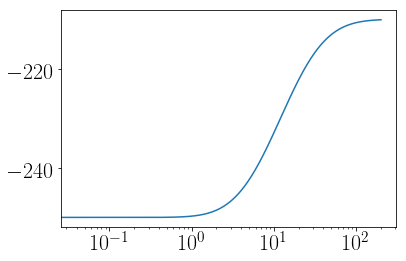

In [50]:
plt.semilogx(x,y3)

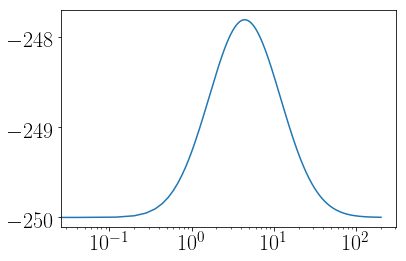

In [51]:
plt.semilogx(x,y4)

40.0


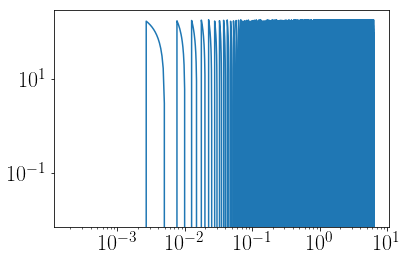

In [62]:
dt = x[1] - x[0]
t1,t2 =SM_inst.transfer_function(x,y1)
plt.loglog(t1[:-1],np.angle(t2,deg=True)[:int(65536/2)])

In [61]:
np.angle(t2, deg=True)

array([  0.        , -13.73016357, -27.46032715, ...,   0.        ,
       180.        ,   0.        ])